# Diabetes Dataset Example

Codebook containing information on each feature: https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf

## Lit Review

2014 BRFSS Diabetes predictor: https://www.cdc.gov/pcd/issues/2019/19_0109.htm


Journal of Global Health Bias in Healthcare: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6875681/

Harvard Bias in Healthcare: https://www.hsph.harvard.edu/ecpe/how-to-prevent-algorithmic-bias-in-health-care/

NLM Bias in Healthcare Mitigation: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10287014/

In [3]:
# imports

import pandas as pd
import numpy as np
import random
import os

# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# import data processing
from sklearn.model_selection import train_test_split

# import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# import custom functions
import sys
sys.path.insert(0, '../')

import joblib
import yaml
from util import *
from bias_aware_gridsearch import *

# remove warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Data Ingestion

In [1]:
# read in 2015 data
# brfss_full = pd.read_csv('archive/2015.csv')

In [69]:
brfss_full.shape

(441456, 330)

In [70]:
brfss_full.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,1.0,1.0,b'01292015',b'01',b'29',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0
1,1.0,1.0,b'01202015',b'01',b'20',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,2.0,2.0,NaN,NaN,2.0
2,1.0,1.0,b'02012015',b'02',b'01',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN
3,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,9.0
4,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0


In [45]:
# select columns
brfss_selected = brfss_full[['DIABETE3',
                                         '_RFHYPE5',  
                                         'TOLDHI2', '_CHOLCHK', 
                                         '_BMI5', 
                                         'SMOKE100', 
                                         'CVDSTRK3', '_MICHD', 
                                         '_TOTINDA', 
                                         '_FRTLT1', '_VEGLT1', 
                                         '_RFDRHV5', 
                                         'HLTHPLN1', 'MEDCOST', 
                                         'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK', 
                                         'SEX', '_PRACE1', '_AGEG5YR', 'EDUCA', 'INCOME2' ]]

In [46]:
brfss_selected.head()

,DIABETE3,_RFHYPE5,TOLDHI2,_CHOLCHK,_BMI5,SMOKE100,CVDSTRK3,_MICHD,_TOTINDA,_FRTLT1,...,MEDCOST,GENHLTH,MENTHLTH,PHYSHLTH,DIFFWALK,SEX,_PRACE1,_AGEG5YR,EDUCA,INCOME2
0,3.0,2.0,1.0,1.0,4018.0,1.0,2.0,2.0,2.0,2.0,...,2.0,5.0,18.0,15.0,1.0,2.0,1.0,9.0,4.0,3.0
1,3.0,1.0,2.0,2.0,2509.0,1.0,2.0,2.0,1.0,2.0,...,1.0,3.0,88.0,88.0,2.0,2.0,1.0,7.0,6.0,1.0
2,3.0,1.0,1.0,1.0,2204.0,NaN,1.0,NaN,9.0,9.0,...,2.0,4.0,88.0,15.0,NaN,2.0,1.0,11.0,4.0,99.0
3,3.0,2.0,1.0,1.0,2819.0,2.0,2.0,2.0,2.0,1.0,...,1.0,5.0,30.0,30.0,1.0,2.0,1.0,9.0,4.0,8.0
4,3.0,1.0,2.0,1.0,2437.0,2.0,2.0,2.0,2.0,9.0,...,2.0,5.0,88.0,20.0,2.0,2.0,1.0,9.0,5.0,77.0


## Data Cleaning

In [48]:
# DIABETE3
# convert to ordinal:
# 0 is for no diabetes or only during pregnancy
# 1 is for pre-diabetes or borderline diabetes
# 2 is for yes diabetes
# Remove all 7 (dont knows)
# Remove all 9 (refused)
brfss_selected['DIABETE3'] = brfss_selected['DIABETE3'].replace({2:0, 3:0, 4:1, 1:2})
brfss_selected = brfss_selected[brfss_selected.DIABETE3 != 7]
brfss_selected = brfss_selected[brfss_selected.DIABETE3 != 9]
brfss_selected.DIABETE3.unique()

/var/folders/rf/h6_7bsv91nscjbz1j5xqns5r0000gp/T/ipykernel_17366/1663848308.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brfss_selected['DIABETE3'] = brfss_selected['DIABETE3'].replace({2:0, 3:0, 4:1, 1:2})


array([ 0.,  2., nan])

In [49]:
#1 _RFHYPE5
# convert to binary:
# 0 represents no high blood pressure
# 1 represents high blood pressure
brfss_selected['_RFHYPE5'] = brfss_selected['_RFHYPE5'].replace({1:0, 2:1})
brfss_selected = brfss_selected[brfss_selected._RFHYPE5 != 9]
brfss_selected._RFHYPE5.unique()

array([1., 0.])

In [50]:
#2 TOLDHI2
# convert to binary:
# 0 represents no
# 1 represents yes
# Remove all 7 (dont knows)
# Remove all 9 (refused)
brfss_selected['TOLDHI2'] = brfss_selected['TOLDHI2'].replace({2:0})
# brfss_df_selected = brfss_df_selected[brfss_df_selected.TOLDHI2 != 7]
# brfss_df_selected = brfss_df_selected[brfss_df_selected.TOLDHI2 != 9]
brfss_selected.TOLDHI2.unique()

array([ 1.,  0., nan,  7.,  9.])

In [21]:
# rename columns for readability
brfss = brfss_selected.rename(columns = {'DIABETE3':'Diabetes_012', 
                                         '_RFHYPE5':'HighBP',  
                                         'TOLDHI2':'HighChol', '_CHOLCHK':'CholCheck', 
                                         '_BMI5':'BMI', 
                                         'SMOKE100':'Smoker', 
                                         'CVDSTRK3':'Stroke', '_MICHD':'HeartDiseaseorAttack', 
                                         '_TOTINDA':'PhysActivity', 
                                         '_FRTLT1':'Fruits', '_VEGLT1':"Veggies", 
                                         '_RFDRHV5':'HvyAlcoholConsump', 
                                         'HLTHPLN1':'AnyHealthcare', 'MEDCOST':'NoDocbcCost', 
                                         'GENHLTH':'GenHlth', 'MENTHLTH':'MentHlth', 'PHYSHLTH':'PhysHlth', 'DIFFWALK':'DiffWalk', 
                                         'SEX':'Sex', '_AGEG5YR':'Age', 'EDUCA':'Education', 'INCOME2':'Income' })

In [22]:
brfss

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,_PRACE1,Age,Education,Income
0,3.0,2.0,1.0,1.0,4018.0,1.0,2.0,2.0,2.0,2.0,...,2.0,5.0,18.0,15.0,1.0,2.0,1.0,9.0,4.0,3.0
1,3.0,1.0,2.0,2.0,2509.0,1.0,2.0,2.0,1.0,2.0,...,1.0,3.0,88.0,88.0,2.0,2.0,1.0,7.0,6.0,1.0
2,3.0,1.0,1.0,1.0,2204.0,NaN,1.0,NaN,9.0,9.0,...,2.0,4.0,88.0,15.0,NaN,2.0,1.0,11.0,4.0,99.0
3,3.0,2.0,1.0,1.0,2819.0,2.0,2.0,2.0,2.0,1.0,...,1.0,5.0,30.0,30.0,1.0,2.0,1.0,9.0,4.0,8.0
4,3.0,1.0,2.0,1.0,2437.0,2.0,2.0,2.0,2.0,9.0,...,2.0,5.0,88.0,20.0,2.0,2.0,1.0,9.0,5.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,1.0,2.0,1.0,1.0,1842.0,2.0,2.0,2.0,2.0,2.0,...,2.0,4.0,88.0,88.0,1.0,2.0,6.0,11.0,2.0,4.0
441452,3.0,1.0,2.0,1.0,2834.0,2.0,2.0,2.0,1.0,1.0,...,2.0,1.0,88.0,88.0,2.0,2.0,6.0,2.0,5.0,2.0
441453,3.0,2.0,1.0,1.0,4110.0,1.0,2.0,2.0,9.0,9.0,...,2.0,4.0,20.0,88.0,2.0,2.0,1.0,11.0,4.0,5.0
441454,3.0,2.0,2.0,1.0,2315.0,2.0,2.0,2.0,2.0,1.0,...,2.0,3.0,88.0,88.0,2.0,1.0,6.0,7.0,5.0,1.0


## EDA

In [4]:
data = pd.read_csv('diabetes_orig.csv')
data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Race,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,0.0,5.0,18.0,15.0,1.0,0.0,1.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,3.0,0.0,0.0,0.0,0.0,1.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,5.0,30.0,30.0,1.0,0.0,1.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,1.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,0.0,2.0,3.0,0.0,0.0,0.0,1.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,0.0,5.0,0.0,1.0,6.0,5.0,6.0,7.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,1.0,0.0,6.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,6.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,0.0,0.0,0.0,1.0,6.0,7.0,5.0,1.0


In [8]:
data.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Race,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,2.191414,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,8.977575,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,99.000000,13.000000,6.000000,8.000000


#### Race

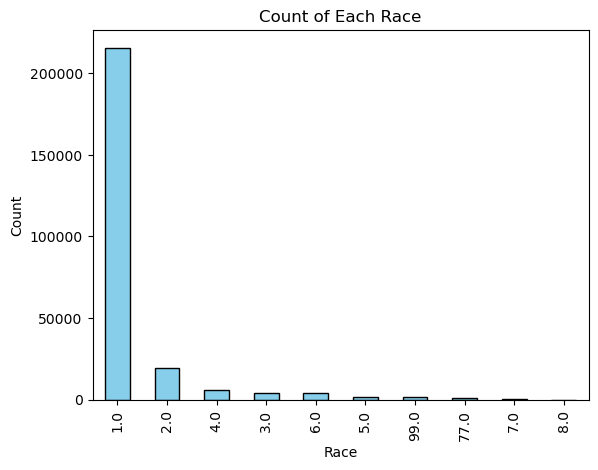

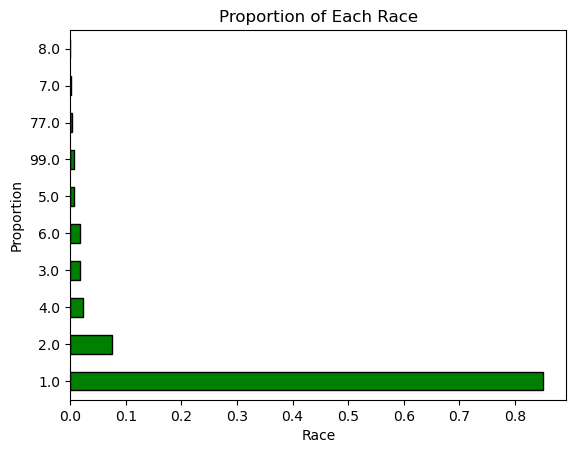

In [62]:
# Bar chart of count of each race within data
race_counts = data['Race'].value_counts()
race_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Count of Each Race')
plt.show()

# Bar plot of proportions of each race represented within the dataset
race_prop = data['Race'].value_counts(normalize = True)
race_prop.plot(kind='barh', color='green', edgecolor='black')
plt.xlabel('Race')
plt.ylabel('Proportion')
plt.title('Proportion of Each Race')
plt.show()

#### Gender

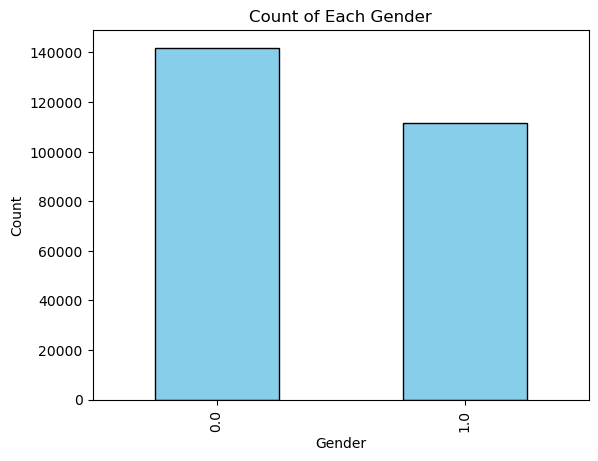

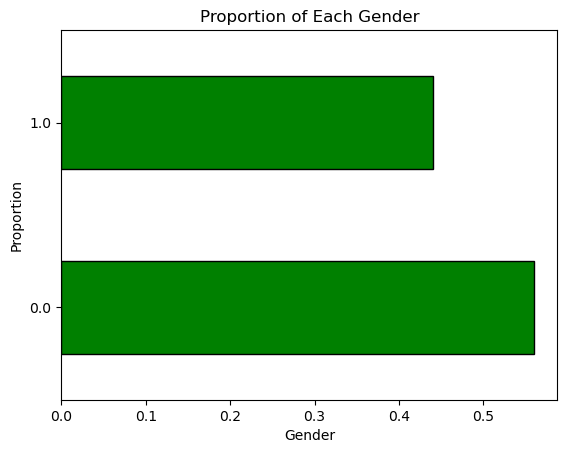

In [63]:
# Bar chart of count of each gender within data
race_counts = data['Sex'].value_counts()
race_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Each Gender')
plt.show()

# Bar plot of proportions of each gender represented within the dataset
race_prop = data['Sex'].value_counts(normalize = True)
race_prop.plot(kind='barh', color='green', edgecolor='black')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.title('Proportion of Each Gender')
plt.show()

#### Age

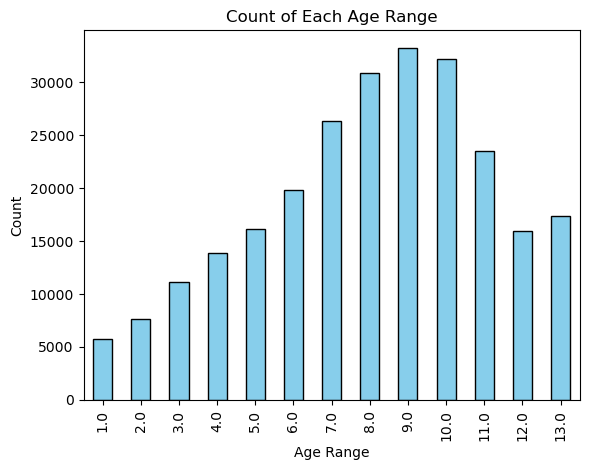

In [64]:
# Count the occurrences of each age range
age_counts = data['Age'].value_counts()

# Sorting the age ranges to display in order
sorted_age_counts = age_counts.sort_index()

# Plotting the bar chart
sorted_age_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.title('Count of Each Age Range')
plt.show()

### (Fix Race Column)

In [2]:
# data['Race'] = data['Race'].replace({1:'White', 2:'African American', 3: 'American Indian/Alaskan Native', 4:
#                                     'Asian', 5:'Native Hawaiian/Pacific Islander', 6:'Other', 7:'Multiracial', 
#                                      77: "N/A", 99:"Refused", 8:"IDK"})
# data["Race"].unique()

## Naive Model

In [5]:
X = data.drop("Diabetes_012", axis=1)
y = data['Diabetes_012']

In [6]:
# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# build naive model
model = RandomForestClassifier(random_state=8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

##### Test Accuracy of Base RF Model

In [7]:
# calculate test accuracy
test_acc = (y_pred == y_test).mean()
print('Testing accuracy:', test_acc)

Testing accuracy: 0.8431291390728477


##### Statistical Parity Difference for Base RF Model

In [8]:
calculate_statistical_parity_difference(data, 'Diabetes_012', 'Sex', 0.0, 1.0, 0)

-0.021729102970409753

## Bias Aware Model

##### Parameters

In [14]:
parent_dir = os.path.dirname(os.getcwd())
params_path = os.path.join(parent_dir, 'params.yaml')

with open(params_path, 'r') as file:
    param_grid_file = yaml.safe_load(file)
    
param_grid = param_grid_file['detailed_rfc_params']
param_grid

{'n_estimators': [50, 100, 200, 300, 400, 500],
 'max_depth': [20, 40, 50, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [2, 5, 10],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_leaf_nodes': [10, 20, 30, 50, 70, 90, 100],
 'class_weight': ['balanced', 'balanced_subsample']}

##### Model Development

In [12]:
train_data = X_train.join(y_train)

model = RandomForestClassifier(random_state=8)
params = {'n_estimators': [20, 30], 'max_depth': [5, 10]}

In [15]:
gridsearch = BiasAwareGridSearchCV(model, params, train_data, 'Diabetes_012', 'Sex', 0.0, 1.0, 0, cv=5, n_jobs= -1, verbose=False)
#gridsearch = BiasAwareGridSearchCV(model, param_grid, train_data, 'Diabetes_012', 'Sex', 0.0, 1.0, cv=5, n_jobs= -1, verbose=False)
gridsearch.fit(X_train, y_train, calculate_statistical_parity_difference)

# gridsearch = joblib.dump(gridsearch, 'grid_search_results.pkl')
gridsearch = joblib.load('grid_search_results.pkl')

### Model Evaluation

##### Most Accurate Model

In [18]:
# normal "best accuracy" model - synonymous to regular gridsearchCV's result
rf_accuracy = gridsearch.select_highest_accuracy_model()
rf_accuracy

RandomForestClassifier(max_depth=10, n_estimators=20, random_state=8)

In [58]:
# training accuracy and spd
pred_train = rf_accuracy.predict(X_train)
result_train = X_train.copy()
result_train['pred'] = pred_train

print("Accuracy: ", (pred_train == y_train).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(result_train, 'pred', 'Sex', 0.0, 1.0, 0))

Accuracy:  0.8520626379690949
Statistical parity difference:  0.004028458355449516


In [55]:
# testing accuracy and spd

print("Accuracy: ", (y_test==rf_accuracy.predict(X_test)).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(result_test, 'pred', 'Sex', 0.0, 1.0, 0))

Accuracy:  0.848707032481867
Statistical parity difference:  0.005226991165505623


##### Least Biased Model

In [19]:
# regardless of accuracy, find which model exhibited lowest training bias
rf_bias = gridsearch.select_least_biased_model()
rf_bias

RandomForestClassifier(max_depth=5, n_estimators=20, random_state=8)

In [52]:
# training accuracy and spd

print("Accuracy: ", (y_train==rf_bias.predict(X_train)).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(result_train, 'pred', 'Sex', 0.0, 1.0, 0))

Accuracy:  0.8425624802901293
Statistical parity difference:  0.00019728761026494013


In [57]:
# testing accuracy and spd

print("Accuracy: ", (y_test==rf_bias.predict(X_test)).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(result_test, 'pred', 'Sex', 0.0, 1.0, 0))

Accuracy:  0.843227688426364
Statistical parity difference:  0.005226991165505623


###### Balanced Model

In [22]:
# considering the top X accuracy models, select the model with the least exhibited training bias
rf_balance = gridsearch.select_balanced_model(5)
rf_balance

RandomForestClassifier(max_depth=5, n_estimators=20, random_state=8)

In [ ]:
# training accuracy and spd

print("Accuracy: ")
print("Statistical parity difference: ")

In [ ]:
# testing accuracy and spd

print("Accuracy: ")
print("Statistical parity difference: ")

##### Optimal Model

In [23]:
# consider the models that had an accuracy within X from the highest accuracy, 
# select the model with the least exhibited bias
rf_optimum = gridsearch.find_optimum_model(50)
rf_optimum

RandomForestClassifier(max_depth=5, n_estimators=20, random_state=8)

In [46]:
# training accuracy and spd

print("Accuracy: ")
print("Statistical parity difference: ")

Accuracy: 
Statistical parity difference: 


In [47]:
# testing accuracy and spd

print("Accuracy: ")
print("Statistical parity difference: ")

Accuracy: 
Statistical parity difference: 


## Results

##### Plotting Parameters

We want to explore how the hyperparameters had an influence on the model's improvement in performance.

In [ ]:
params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes']
for param in params:
    gridsearch.plot_params(param)

## Conclusion